# MRF Estimation.  

**This notebook is the first implementation of a segmented MRFs **




In [1]:
# Ignore Warnings
from warnings import simplefilter
simplefilter('ignore')

%reload_ext autoreload
%autoreload 2

In [2]:
# Dependencies - General Stuff
import sys
import os
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from glob import glob
from scipy.signal import windows, fftconvolve
from scipy.io import wavfile
from scipy.special import genlaguerre
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
import seaborn as sns

# Depednecies from Theunissen Lab
# sys.path.append("/Users/frederictheunissen/Code/soundsig/")
from soundsig.sound import BioSound
from soundsig.sound import spec_colormap

# strfpy
sys.path.append("/Users/frederictheunissen/Code/strfPy/module/")
from strfpy.makePSTH import SpikeResponse
from strfpy import findDatasets, preprocSound, strfSetup, trnDirectFit, plotTfrep
# from strflab import preprocess_sound, srdata2strflab, linInit, strfData, trnDirectFit, strfOpt


# %matplotlib widget
plt.ion();

Set up the path

In [3]:
# Change these paths to point at your data and stimulus directories
path_base = os.path.join('/Users/frederictheunissen/Code/strfPy')
path_base = '/aquila_ssd2/lthomas/Projects/pySTRF_exampledata'
# dataDir = os.path.join(path_base, 'data')  # contains stim/response pairs
stimsDir = os.path.join(path_base, 'all_stims')  # contains the .wav files


load and visualize single unit data from Theunissen lab

In [129]:
# Specify the directory for three brain regions and three example neurons in each
cellDirName = 'l2a_good'
cellDir = os.path.join(path_base,cellDirName, 'conspecific')


In [130]:
# Get the stimulus and response files from the cell directory
datasets = findDatasets.find_datasets(cellDir, stimsDir)
cellStimDir = datasets['dirname']
stimFiles = datasets['srPairs']['stimFiles']  # paths to .wav files
respFiles = datasets['srPairs']['respFiles']  # paths to spike* files

In [131]:
# Preprocess the sound stimuli by taking the short time Fourier transform, and preprocess the raw spike
# times into PSTHs for each stim/response pair.
preprocDir = os.path.join(cellStimDir, 'preproc') # cache the preprocessed data here
os.makedirs(preprocDir, exist_ok=True)
preprocOptions = {} # we'll leave this empty and use default options


In [132]:
# Make a directory to save figures
figDir = os.path.join(cellStimDir, 'figures')
os.makedirs(figDir, exist_ok=True)

In [133]:
# set up datasets
srData = preprocSound.preprocess_sound(stimFiles, respFiles, preprocess_type='ft', stim_params = preprocOptions, output_dir = preprocDir)
pairCount = len(srData['datasets']) # number of stim/response pairs
nStimChannels = srData['nStimChannels']


### Generate the stimulus and response feature
The stimulus features are the MPS obtained for each song segment.  The song segments are obtained using a hard threshold and then merging short silences and short sounds.
The response feature is the PSTH smoothed with a hanning window.

In [217]:
# Segmentation based on derivative of the envelope
plot = False
ampThresh = 20.0  # Threshold in dB where 50 is max

minSound = 25  # Minimum distance between peaks or troffs
derivativeThresh = 0.3  # Thresnold derivative 0.5 dB per ms.
segmentBuffer = 10 # Number of points on each side of segment for response and MPS - time units given by stim sample rate
respChunkLen = 200 # Total chunk length (including segment buffer) in number of points 
DBNOISE = 60  # Set a baseline for everything below 70 dB from max


wHann = windows.hann(21, sym=True)   # The 21 ms (number of points) hanning window used to smooth the PSTH
wHann = wHann/sum(wHann)

srData

for iSet in range(pairCount) :
    events = dict({
        'index': [],
        'feature': [[]],
    })

    # Stimulus wave file and amplitude enveloppe from spectrogram
    waveFile = srData['datasets'][iSet]['stim']['rawFile']
    fs , soundStim = wavfile.read(waveFile)
    soundLen = soundStim.size
    spectro = np.copy(srData['datasets'][iSet]['stim']['tfrep']['spec'])
    dBMax = spectro.max()
    spectro[spectro < dBMax-DBNOISE] = dBMax-DBNOISE

    ampenv = np.mean(spectro, axis=0)
    ampfs = srData['datasets'][iSet]['stim']['sampleRate']

    nSound = int((respChunkLen)*fs/ampfs)   # number of time points in sound chunks - should be the same for all stimulus-response pairs

    ampenv = np.convolve(ampenv, wHann, mode='same')
    ampdev = ampenv[1:]-ampenv[0:-1]
    
    # Find peaks and troughs
    peakInd, peakVals = find_peaks(ampdev, height = derivativeThresh, distance=minSound)
    troughInd, troughVals = find_peaks(-ampdev, height= derivativeThresh, distance=minSound)
    events['index'].extend(peakInd)
    events['onoff_feature'] =  np.vstack([np.ones(len(peakInd), dtype=int), np.zeros(len(peakInd), dtype=int)]).T
    events['index'].extend(troughInd)
    events['onoff_feature'] = np.concatenate( [events['onoff_feature'],np.vstack([np.zeros(len(troughInd), dtype=int), np.ones(len(troughInd), dtype=int)]).T])
    # sort the features by index
    events['onoff_feature'] = events['onoff_feature'][np.argsort(events['index'])]
    events['index'] = np.sort(events['index'])

    # now get the features from the spectrogram

    # pad the spectrogram with zeros to make sure we have enough points for windowing
    padded_spect = np.pad(spectro, ((0,0), (respChunkLen, respChunkLen)), 'constant', constant_values=(dBMax-DBNOISE, dBMax-DBNOISE))
    # now get the sliding window view
    spect_windows = np.lib.stride_tricks.sliding_window_view(padded_spect, respChunkLen,axis=1)
    # now get the indices of the start of the spectrograms
    # for ON features we take the index of the peak and subtract the segment buffer
    # for OFF features we take the index of the trough and subtract the respChunkLen
    spect_inds = events['index'] + respChunkLen - segmentBuffer * events['onoff_feature'][:,0] - (respChunkLen - segmentBuffer) * events['onoff_feature'][:,1]
    events['spect_windows'] = spect_windows[:, spect_inds,:].swapaxes(0,1)
    events['spect_inds'] = spect_inds

    # now create the features
    nFeats = nStimChannels*respChunkLen
    spect_feats = events['spect_windows'].reshape((len(events['index']), nFeats))
    srData['datasets'][iSet]['events'] = events

    # smooth the psth
    srData['datasets'][iSet]['resp']['psth_smooth'] = np.convolve(srData['datasets'][iSet]['resp']['psth'], wHann, mode='same')

    if plot:
        plt.figure(figsize=(8,2), dpi=100)
        plt.plot(ampdev)
        plt.axhline(derivativeThresh, color = 'k')

        for soundStart in peakInd:
            soundFinish = np.argwhere(troughInd >= soundStart + minSound)
            if soundFinish.shape[0]:
                dt = troughInd[soundFinish[0][0]]-soundStart
                # print (soundStart, soundEnd[soundFinish[0][0]], dt)   
                if dt < minSound:
                    print('WARNING - not expecting short sound here', int(soundStart), int(troughInd[soundFinish[0][0]]+1))

        for soundStart in peakInd:
            plt.plot([soundStart, soundStart], [0, np.max(ampdev)*1.1], 'r')

        for soundEnd in troughInd:
            plt.plot([soundEnd, soundEnd], [0, -np.max(ampdev)*1.1], 'b')


In [174]:
# Use PCA to reduce the dimensionality of the spectrogram features
all_spect_windows = np.concatenate([srData['datasets'][iSet]['events']['spect_windows'].reshape((len(srData['datasets'][iSet]['events']['index']), nFeats)) for iSet in range(pairCount)], axis=0)
npcs = 20
pca = PCA(n_components=npcs)
pca.fit(all_spect_windows)
for iSet in range(pairCount):
    on_off_features = srData['datasets'][iSet]['events']['onoff_feature']
    n_events = len(srData['datasets'][iSet]['events']['index'])
    spect_pca_features = pca.transform(srData['datasets'][iSet]['events']['spect_windows'].reshape((n_events, nFeats)))
    srData['datasets'][iSet]['events']['spect_pca_features'] = np.zeros((n_events, 2*npcs))
    srData['datasets'][iSet]['events']['spect_pca_features'][on_off_features[:,0]==1,0:npcs] = spect_pca_features[on_off_features[:,0]==1,:]
    srData['datasets'][iSet]['events']['spect_pca_features'][on_off_features[:,1]==1,npcs:] = spect_pca_features[on_off_features[:,1]==1,:]



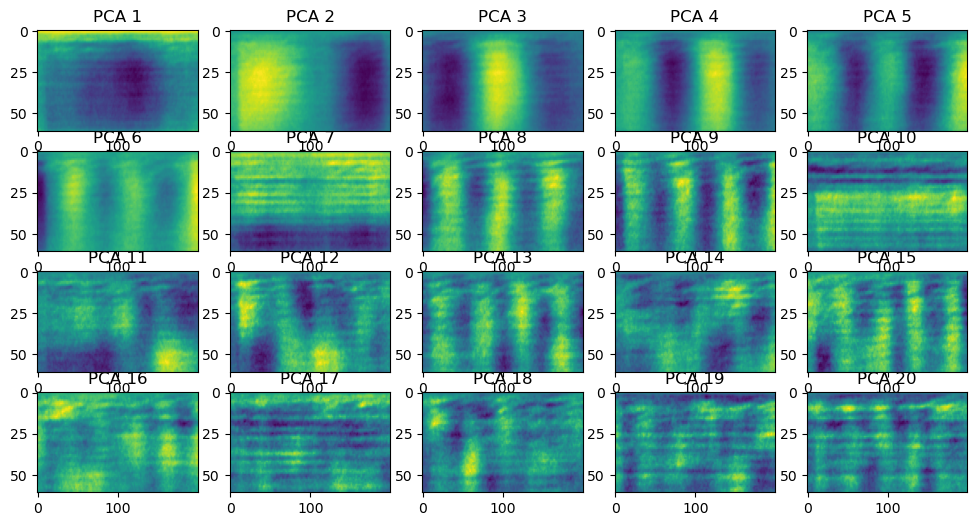

In [175]:
# plot pca components, two rows of 5
nCols = 5
nRows = npcs // nCols
fig, axs = plt.subplots(nRows, nCols, figsize=(12, 6))
for i in range(npcs):
    ax = axs[i // nCols, i % nCols]
    ax.imshow(pca.components_[i].reshape(nStimChannels, respChunkLen), aspect='auto', cmap='viridis')
    ax.set_title(f'PCA {i+1}')

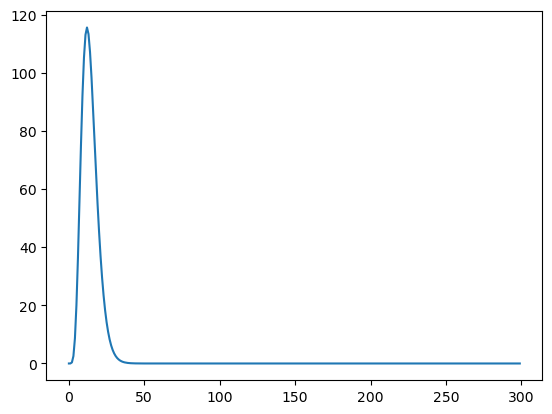

In [176]:
def laguerre(amp, tau, alpha, xorder, npts ):
    xt = np.arange(npts)
    return amp * np.exp(-xt/tau)*np.power(xt/tau, alpha)*genlaguerre(xorder, alpha)(xt/tau)
x_t = np.arange(0,300)
laguerre_func_1_amp = laguerre(amp=1, tau=2, alpha=6,xorder=0,npts=300)
plt.plot(x_t, laguerre_func_1_amp)


In [177]:
# To generate features we will convolve the laguerre function with the feature values
def generate_laguerre_features(pair, feature_key, nLaguerrePoints=300, nLaguerre=5, laguerre_dt_s=0, laguerre_amp=1, laguerre_tau=5, laguerre_alpha=5):
    # we will generate X and Y for each pair
    nT = pair['resp']['psth'].size
    nFeatures = pair['events'][feature_key].shape[1]
    X = np.zeros((nFeatures*nLaguerre, nT))
    # laguerre functions for each order
    # the order of the matrix's rows are: Laguerre order 0-nLaguerre for feature 1, Laguerre order 0-0-nLaguerre for feature 2, ...
    laguerre_mat = np.zeros(( nFeatures*nLaguerre,nLaguerrePoints))
    for iLaguerre in range(nLaguerre):
        laguerre_func = laguerre(amp=laguerre_amp, tau=laguerre_tau, alpha=laguerre_alpha, xorder=iLaguerre, npts=nLaguerrePoints)
        laguerre_mat[iLaguerre::nLaguerre,:] = laguerre_func[np.newaxis,:]
    # for each event we will convolve the laguerre function with the feature value
    inds = pair['events']['index'] + int(laguerre_dt_s*srData['datasets'][iSet]['resp']['sampleRate'])
    inds = np.clip(inds, 0, nT-1)
    X[:,pair['events']['index']] = np.hstack([pair['events'][feature_key]]*nLaguerre).T
    # now convolve the laguerre function with the feature value
    X = fftconvolve(X, laguerre_mat, axes=1, mode='full')[:,:nT]
    return X

X = generate_laguerre_features(srData['datasets'][iSet], 'onoff_feature', nLaguerrePoints=300, nLaguerre=5, laguerre_dt_s=0, laguerre_amp=1, laguerre_tau=5, laguerre_alpha=5)
X.shape

(10, 1899)

Text(0.5, 1.0, 'Alpha')

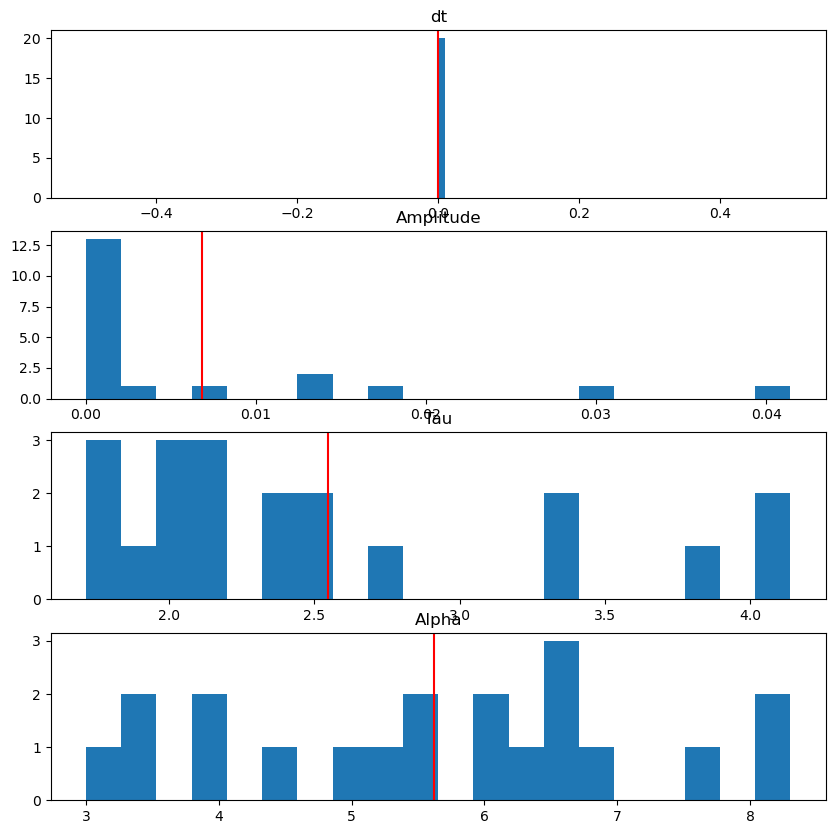

In [178]:
vals = []
# first we will fit the laguerre functions to the data
# TODO do we want to fit differnt values for onsets and offsets?
for iSet in range(pairCount):
    nFeatures = srData['datasets'][iSet]['events']['onoff_feature'].shape[1]
    y = srData['datasets'][iSet]['resp']['psth_smooth']
    amp_ratio = max(y)/max(laguerre_func_1_amp)
    def laguerre_fit_func(pair, dt, amp, tau, alpha):
        return generate_laguerre_features(pair, feature_key='onoff_feature', nLaguerrePoints=300, nLaguerre=1, laguerre_dt_s=dt, 
                                        laguerre_amp=amp, laguerre_tau=tau, laguerre_alpha=alpha).sum(axis=0)
    popt, pcov = curve_fit(laguerre_fit_func, srData['datasets'][iSet], y, p0=np.array([0, amp_ratio, 2, 5]),
                                                                    bounds=([-.02, -np.inf, -np.inf, -np.inf], [.02, np.inf, np.inf, np.inf]))
    vals.append(popt)
predicted_vals = np.array(vals)
avg_vals = np.mean(predicted_vals, axis=0)

# plot the distributions
fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(10,10))
ax0.hist(predicted_vals[:,0], bins=100)
ax0.axvline(avg_vals[0], color='r')
ax0.set_title('dt')
ax1.hist(predicted_vals[:,1], bins=20)
ax1.axvline(avg_vals[1], color='r')
ax1.set_title('Amplitude')
ax2.hist(predicted_vals[:,2], bins=20)
ax2.axvline(avg_vals[2], color='r')
ax2.set_title('Tau')
ax3.hist(predicted_vals[:,3], bins=20)
ax3.axvline(avg_vals[3], color='r')
ax3.set_title('Alpha')



<Axes: ylabel='Density'>

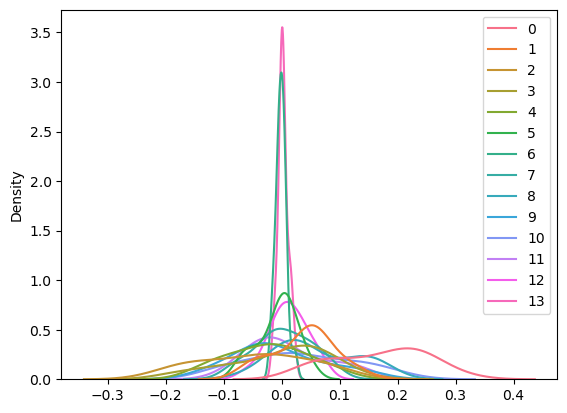

In [179]:
# now lets fit some weights
def fit_laguerre_weights(pair, lag_vals, **kwargs):
    X = generate_laguerre_features(pair, feature_key='onoff_feature', laguerre_dt_s=lag_vals[0], laguerre_amp=lag_vals[1], laguerre_tau=lag_vals[2], laguerre_alpha=lag_vals[3], **kwargs)
    y = pair['resp']['psth_smooth']
    clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
    clf.fit(X.T, y)
    return clf.coef_

weights = []
nLaguerre = 7
for iSet in range(pairCount):
    w = fit_laguerre_weights(srData['datasets'][iSet], avg_vals, nLaguerrePoints=300, nLaguerre=nLaguerre)
    weights.append(w)
weights = np.array(weights)
avg_weights = np.mean(weights, axis=0)

# plot the distributions
sns.kdeplot(weights)

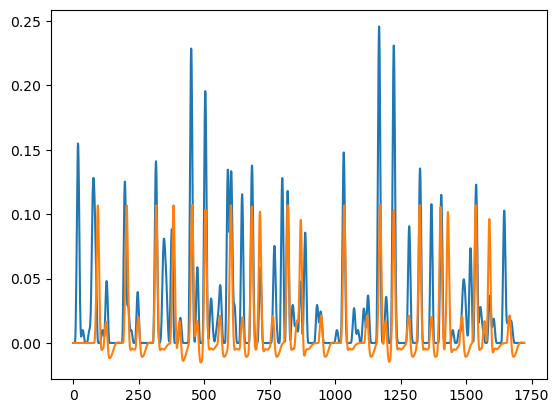

In [180]:
# pick a random pair to plot
iSet = np.random.randint(pairCount)
pair = srData['datasets'][iSet]
X = generate_laguerre_features(pair, feature_key='onoff_feature', laguerre_dt_s=avg_vals[0], laguerre_amp=avg_vals[1], laguerre_tau=avg_vals[2], laguerre_alpha=avg_vals[3], nLaguerrePoints=300, nLaguerre=nLaguerre)
y = pair['resp']['psth_smooth']
y_pred = X.T @ avg_weights
plt.plot(y)
plt.plot(y_pred)

In [181]:
# now lets generate the predicted response using the spectrogram feautres
# now lets fit some weights
Alphas = (1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10)   # Ridge hyperparameter coeffiecients
def fit_laguerre_weights(pair, lag_vals, **kwargs):
    X = generate_laguerre_features(pair, feature_key='spect_pca_features', laguerre_dt_s=lag_vals[0], laguerre_amp=lag_vals[1], laguerre_tau=lag_vals[2], laguerre_alpha=lag_vals[3], **kwargs)
    y = pair['resp']['psth_smooth']
    clf = RidgeCV(alphas=Alphas)
    clf.fit(X.T, y)
    return clf.coef_

weights = []
for iSet in range(pairCount):
    w = fit_laguerre_weights(srData['datasets'][iSet], avg_vals, nLaguerrePoints=300, nLaguerre=nLaguerre)
    weights.append(w)
    
weights = np.array(weights)
avg_weights = np.mean(weights, axis=0)


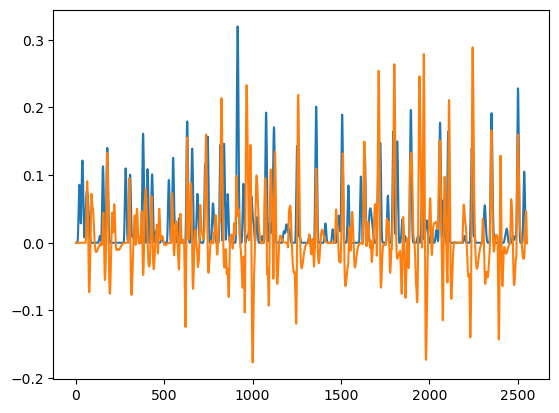

In [190]:
# pick a random pair to plot
iSet = np.random.randint(pairCount)
pair = srData['datasets'][iSet]
X = generate_laguerre_features(pair, feature_key='spect_pca_features', laguerre_dt_s=avg_vals[0], laguerre_amp=avg_vals[1], laguerre_tau=avg_vals[2], laguerre_alpha=avg_vals[3], nLaguerrePoints=300, nLaguerre=nLaguerre)
y = pair['resp']['psth_smooth']
y_pred = X.T @ avg_weights#weights[iSet]
plt.plot(y)
plt.plot(y_pred)

In [210]:
# now lets concatenate all responses and features and do one big ridge regression

X = None
Y= None
pair_test_set = np.random.choice(range(pairCount), 5, replace=False)
for iSet in range(pairCount):
    if iSet in pair_test_set:
        continue
    pair = srData['datasets'][iSet]
    x = generate_laguerre_features(pair, feature_key='spect_pca_features', laguerre_dt_s=avg_vals[0], laguerre_amp=avg_vals[1], laguerre_tau=avg_vals[2], laguerre_alpha=avg_vals[3], nLaguerrePoints=300, nLaguerre=nLaguerre)
    if X is None:
        X = x
    else:
        X = np.hstack([X, x])
    if Y is None:
        Y = pair['resp']['psth_smooth']
    else:
        Y = np.hstack([Y, pair['resp']['psth_smooth']])


In [211]:
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
clf.fit(X.T, Y)


RidgeCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]))

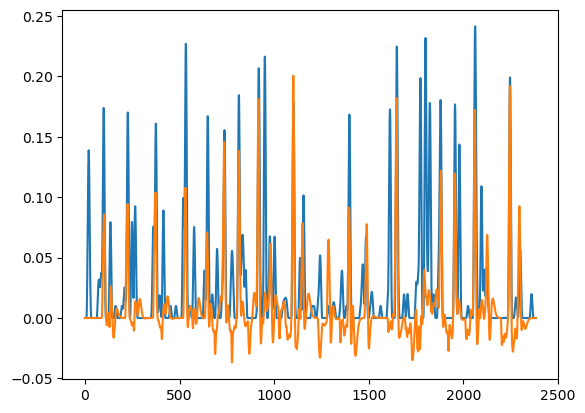

In [216]:
iSet = np.random.choice(pair_test_set)
pair = srData['datasets'][iSet]
X = generate_laguerre_features(pair, feature_key='spect_pca_features', laguerre_dt_s=avg_vals[0], laguerre_amp=avg_vals[1], laguerre_tau=avg_vals[2], laguerre_alpha=avg_vals[3], nLaguerrePoints=300, nLaguerre=nLaguerre)
y = pair['resp']['psth_smooth']
y_pred = X.T @ clf.coef_
plt.plot(y)
plt.plot(y_pred)

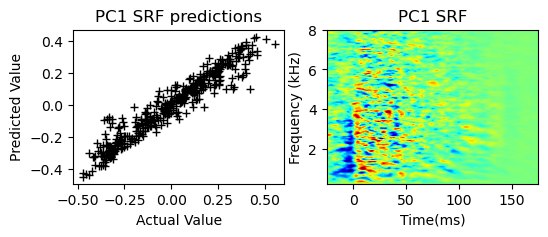

In [233]:
plt.figure(figsize=(6,2), dpi = 100)

plt.subplot(1,2,1)
plt.plot(respPC[:,0], respPCPredSpect[:,0], 'k+')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('PC1 SRF predictions')

plt.subplot(1,2,2)
SRFPlot = SRF[0,:].reshape(stimSpect.shape[1], stimSpect.shape[2])
maxabs = np.max((SRFPlot.max(), -SRFPlot.min()))
cmap = plt.get_cmap('jet')
ex = (-segmentBuffer, respChunkLen-segmentBuffer , 0.25, 8)
plt.imshow(SRFPlot, interpolation='spline16', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time(ms)')
plt.title('PC1 SRF')

plt.clim((-maxabs*0.8, maxabs*0.8))

plt.savefig(os.path.join(figDir, 'PC1_SRF.eps'))

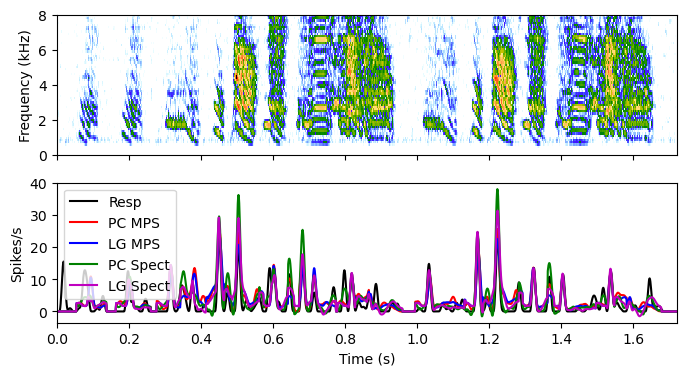

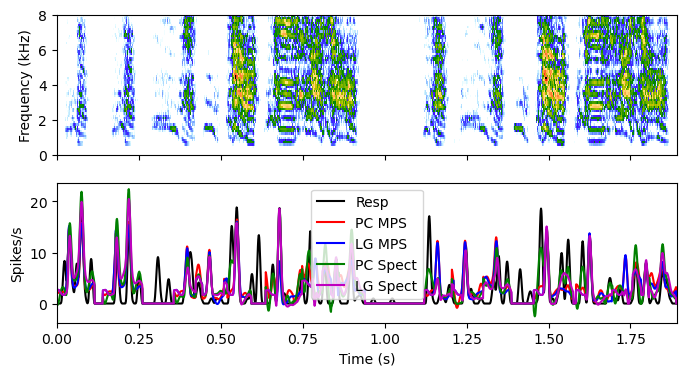

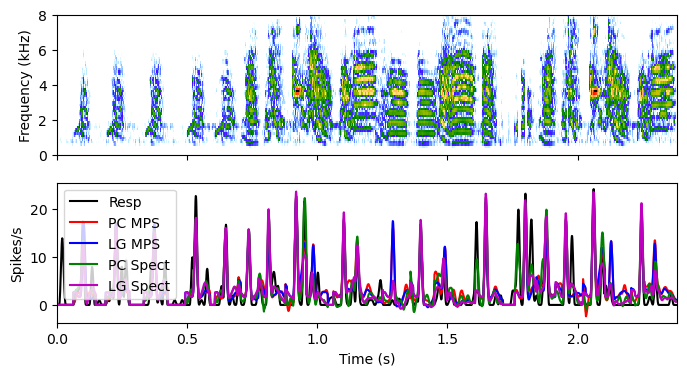

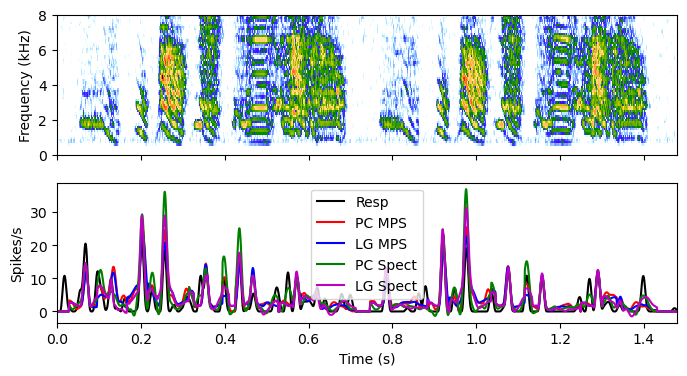

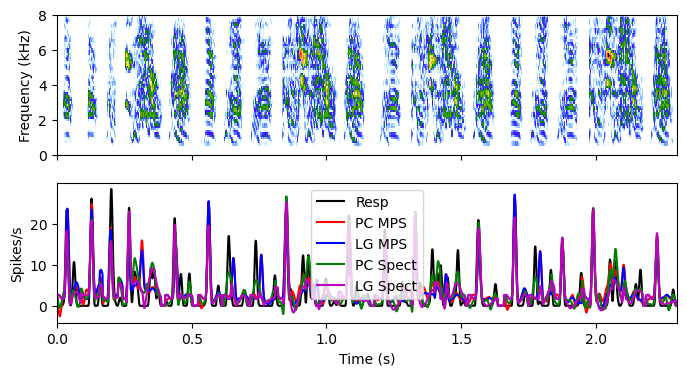

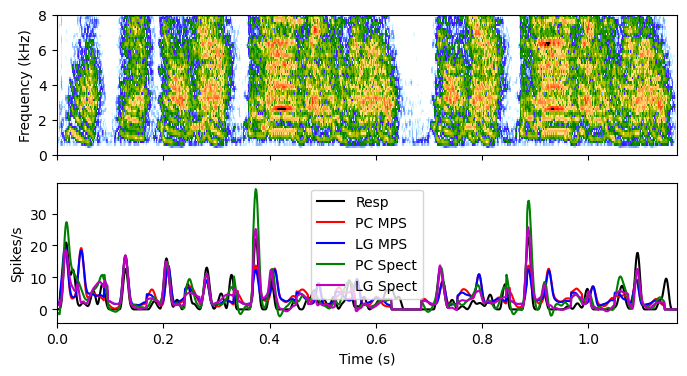

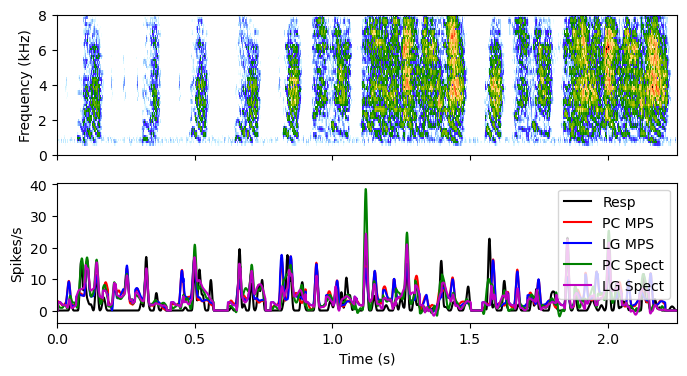

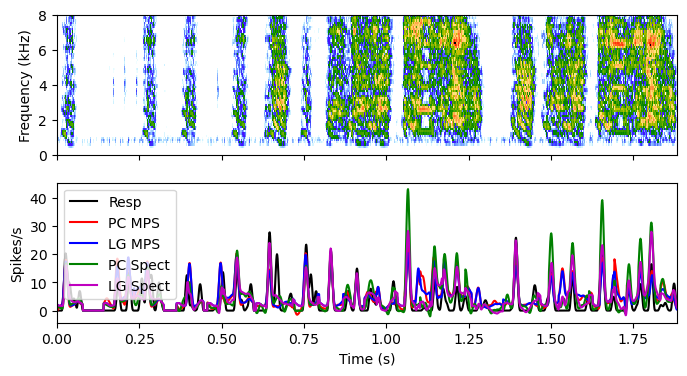

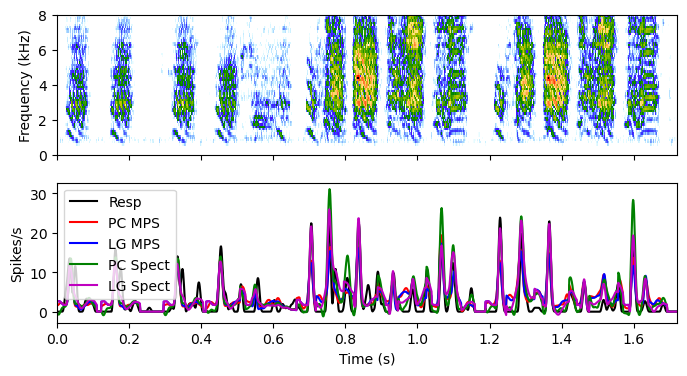

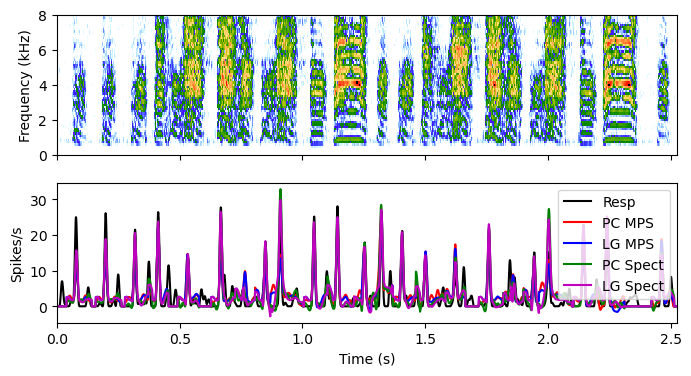

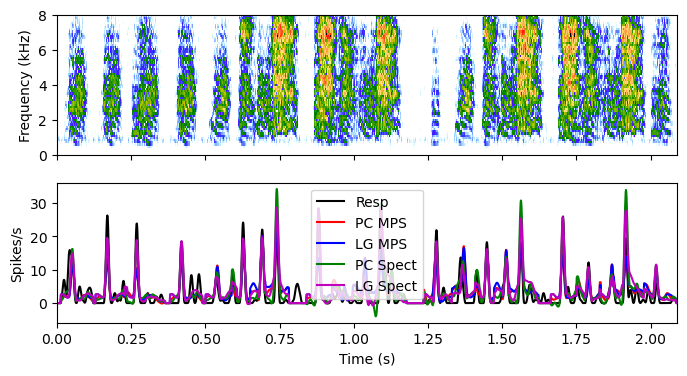

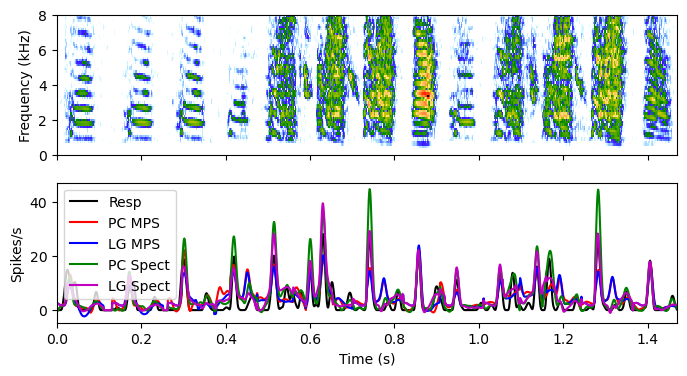

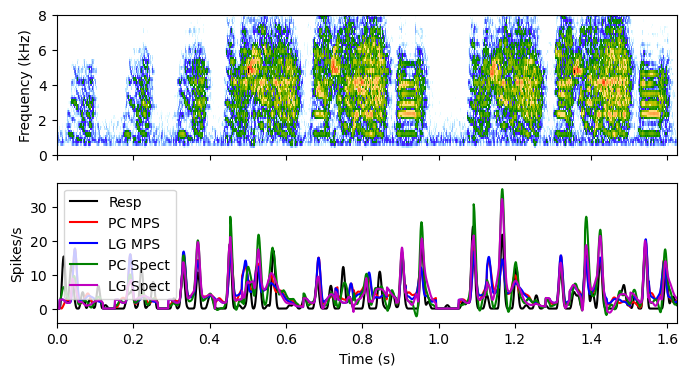

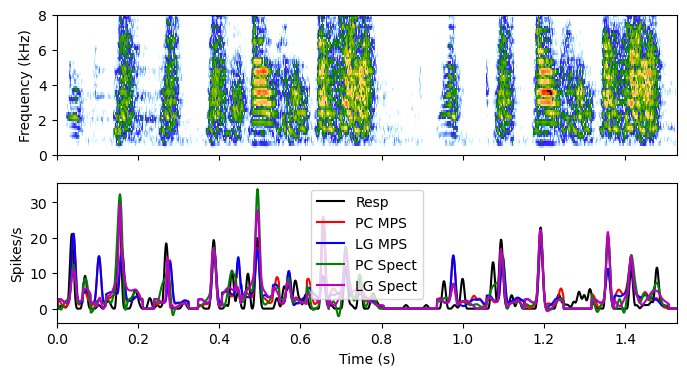

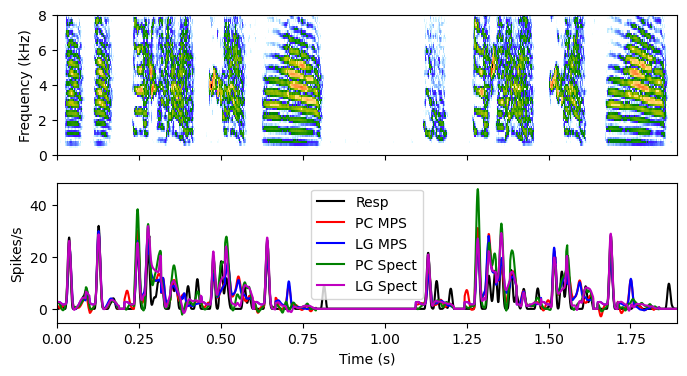

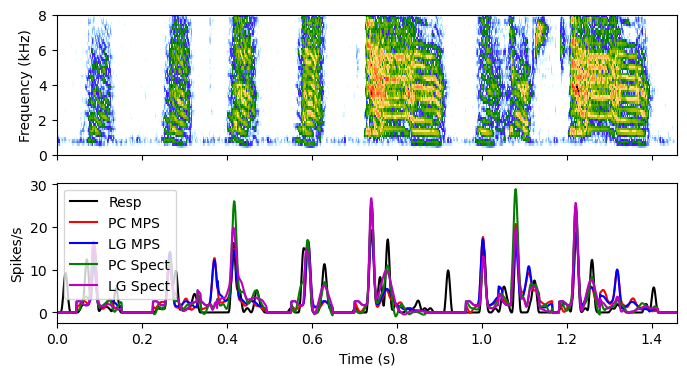

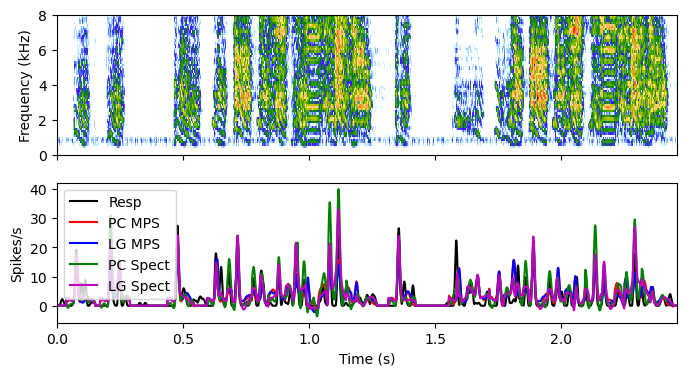

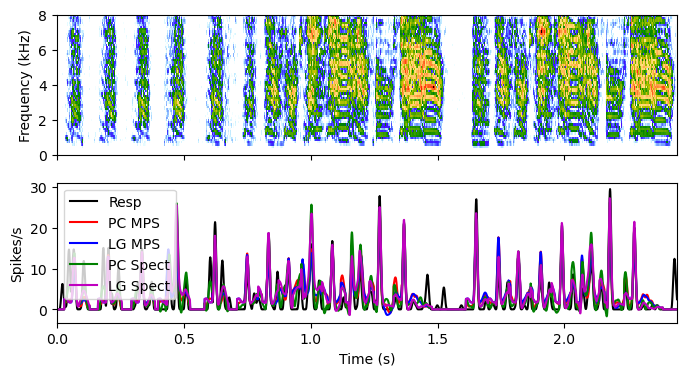

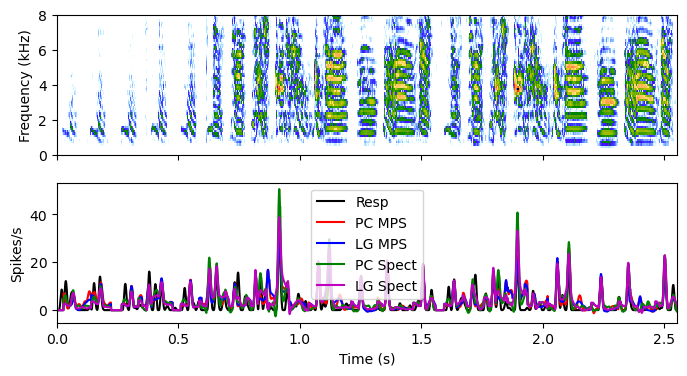

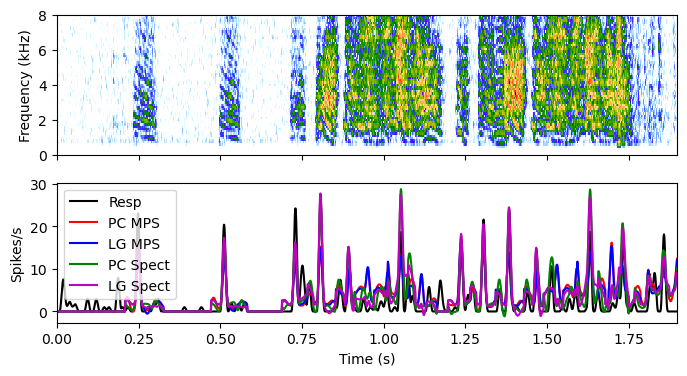

In [234]:
# Generate, Store and Plot the Predictions by rejoining the predictions for each segment.
# Note that we are only using the positive R2

# Making variables for the concatenated predictions
concatPredRespPCMPS = np.array([])
concatPredRespPCSpect = np.array([])
concatPredRespLGMPS = np.array([])
concatPredRespLGSpect = np.array([])
concatResp = np.array([])

# We are calculating these for a coherence estimation but this is not happening yet.
concatPsthHalf1 = np.array([])
concatPsthHalf2 = np.array([])
pairCountTrials = np.zeros(pairCount)

nChunk = len(respMPS)
DBNOISE = 50  # Color Threshold for spectrogram


# Color map for spectrograms
spec_colormap()   # defined in sound.py

for iSet in range(pairCount) :

    # Get the stimulus (spectrogram) and the response
    ds = srData['datasets'][iSet]
    resp = ds['resp']['psth']
    tfrep = ds['stim']['tfrep']
    respSmoothed = np.convolve(resp, wHann, mode='same')
    
    # Generate the prediction
    respPredictionPCMPS = np.zeros(respSmoothed.shape)
    respPredictionLGMPS = np.zeros(respSmoothed.shape)
    respPredictionPCSpect = np.zeros(respSmoothed.shape)
    respPredictionLGSpect = np.zeros(respSmoothed.shape)

    for iChunk in range(nChunk):
        if (chunkID['set'][iChunk] == iSet):
            
            # Start the prediction with the mean PC
            respPredictionPCMPS[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += pcResp.mean_[segmentBuffer:chunkID['respIndEnd'][iChunk]]
            respPredictionPCMPS[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += pcResp.mean_[chunkID['respIndStart'][iChunk]:segmentBuffer]
            respPredictionPCSpect[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += pcResp.mean_[segmentBuffer:chunkID['respIndEnd'][iChunk]]
            respPredictionPCSpect[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += pcResp.mean_[chunkID['respIndStart'][iChunk]:segmentBuffer]

            # or the mean response
            respPredictionLGMPS[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += meanResp[segmentBuffer:chunkID['respIndEnd'][iChunk]]
            respPredictionLGMPS[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += meanResp[chunkID['respIndStart'][iChunk]:segmentBuffer]
            respPredictionLGSpect[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += meanResp[segmentBuffer:chunkID['respIndEnd'][iChunk]]
            respPredictionLGSpect[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += meanResp[chunkID['respIndStart'][iChunk]:segmentBuffer]
            
            # Now add contribution of each PC fit if R2 above threshold
            for iPC in range(nPC):
                if (r2PC[iPC] > 0.01) :
                    respPredictionPCMPS[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respPCPred[iChunk, iPC]*pcResp.components_[iPC,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                    respPredictionPCMPS[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respPCPred[iChunk, iPC]*pcResp.components_[iPC,chunkID['respIndStart'][iChunk]:segmentBuffer]
                
                if (r2PCSpect[iPC] > 0.01) :
                    respPredictionPCSpect[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respPCPredSpect[iChunk, iPC]*pcResp.components_[iPC,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                    respPredictionPCSpect[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respPCPredSpect[iChunk, iPC]*pcResp.components_[iPC,chunkID['respIndStart'][iChunk]:segmentBuffer]

            # Same for the Laguerre polynomials
            for iLG in range(nLG):
                if (r2LG[iLG] > 0.01) :
                    if iLG < order:
                        respPredictionLGMPS[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respLGPred[iChunk, iLG]*onsetLG[iLG,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                        respPredictionLGMPS[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respLGPred[iChunk, iLG]*onsetLG[iLG,chunkID['respIndStart'][iChunk]:segmentBuffer]
                    else:
                        respPredictionLGMPS[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respLGPred[iChunk, iLG]*sustainedLG[iLG-order,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                        respPredictionLGMPS[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respLGPred[iChunk, iLG]*sustainedLG[iLG-order,chunkID['respIndStart'][iChunk]:segmentBuffer]
                if (r2LGSpect[iLG] > 0.01) :
                    if iLG < order:
                        respPredictionLGSpect[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respLGPredSpect[iChunk, iLG]*onsetLG[iLG,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                        respPredictionLGSpect[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respLGPredSpect[iChunk, iLG]*onsetLG[iLG,chunkID['respIndStart'][iChunk]:segmentBuffer]
                    else:
                        respPredictionLGSpect[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respLGPredSpect[iChunk, iLG]*sustainedLG[iLG-order,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                        respPredictionLGSpect[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respLGPredSpect[iChunk, iLG]*sustainedLG[iLG-order,chunkID['respIndStart'][iChunk]:segmentBuffer]





    
    # Store the prediction and the actual response in a single vector to calculate predition quality
    concatPredRespPCMPS = np.concatenate((concatPredRespPCMPS, respPredictionPCMPS))
    concatPredRespPCSpect = np.concatenate((concatPredRespPCSpect, respPredictionPCSpect))
    concatPredRespLGMPS = np.concatenate((concatPredRespLGMPS, respPredictionLGMPS))
    concatPredRespLGSpect = np.concatenate((concatPredRespLGSpect, respPredictionLGSpect))

    concatResp = np.concatenate((concatResp, respSmoothed))

    # Get raw spike data divided into two for coherency calculations
    psthdata = preprocSound.split_psth(ds['resp']['rawSpikeIndicies'], resp.shape[0])
    concatPsthHalf1 = np.concatenate((concatPsthHalf1, psthdata['psth_half1']))
    concatPsthHalf2 = np.concatenate((concatPsthHalf2, psthdata['psth_half2']))
    numTrials = len(ds['resp']['rawSpikeTimes'])  # One needs to check that all numTrials are equal
    pairCountTrials[iSet] = numTrials
    
    # Plot the spectrogram and the prediction
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))

    # The spectrogram
    soundSpect = np.copy(tfrep['spec'])
    maxB = soundSpect.max()
    minB = maxB-DBNOISE
    soundSpect[soundSpect < minB] = minB
    minSpect = soundSpect.min()
    cmap = plt.get_cmap('SpectroColorMap')
    ax1.imshow(tfrep['spec'], extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
    ax1.set_ylim(0, 8)
    ax1.set_ylabel('Frequency (kHz)')
    # ax1.set_xlabel('Time (s)')

    # The prediction
    fac = ds['resp']['sampleRate']/numTrials   # The response is in sample rate (usually ms) and summed over trials. Here we correct to get spikes/s
    ax2.plot(tfrep['t'], respSmoothed*fac, 'k', label='Resp')
    ax2.plot(tfrep['t'], respPredictionPCMPS*fac, 'r', label='PC MPS')
    ax2.plot(tfrep['t'], respPredictionLGMPS*fac, 'b', label='LG MPS')
    ax2.plot(tfrep['t'], respPredictionPCSpect*fac, 'g', label='PC Spect')
    ax2.plot(tfrep['t'], respPredictionLGSpect*fac, 'm', label='LG Spect')
    ax2.set_ylabel('Spikes/s')
    ax2.set_xlabel('Time (s)')
    plt.legend()

    # This code is to save figures for papers, etc including the modulation power spectrum of different chunks
    if iSet  == -1 :
        plt.savefig(os.path.join(figDir, 'stimRespMRFPred%d.eps' % (iSet)))
        for iChunk in range(nChunk):
            if (chunkID['set'][iChunk] == iSet):
                plt.figure(figsize=(2,2), dpi = 100)
                MPSPlot = stimMPSFeat[iChunk,:].reshape(len(indwf), len(indwt))
                maxabs = np.max((MPSPlot.max(), -MPSPlot.min()))
                cmap = plt.get_cmap('jet')
                ex = (wt[indwt].min(), wt[indwt].max(), wf[indwf].min()*1e3, wf[indwf].max()*1e3)
                plt.imshow(MPSPlot, interpolation='spline16', aspect='auto', origin='lower', cmap=cmap, extent=ex)
                
                plt.ylim((0,4))
                plt.xlim((-50, 50))
                plt.clim((-maxabs*0.8, maxabs*0.8))
                plt.axis('off')
                plt.savefig(os.path.join(figDir, 'stimMPSChunk%d_%d.eps' % (iSet, iChunk)))

 
            



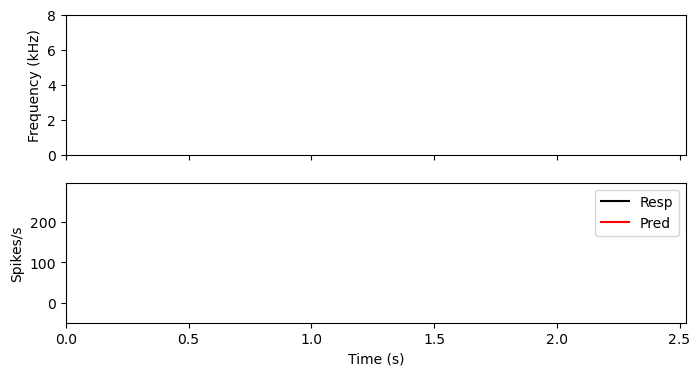

In [41]:
# Add an animation
nChunk = len(respMPS)
DBNOISE = 50  # Color Threshold for spectrogram
iSet = 9      # The one to plot/animate

# Color map for spectrograms
spec_colormap()   # defined in sound.py

# Get the stimulus (spectrogram) and the response
ds = srData['datasets'][iSet]
resp = ds['resp']['psth']
tfrep = ds['stim']['tfrep']
numTrials = len(ds['resp']['rawSpikeTimes']) 
respSmoothed = np.convolve(resp, wHann, mode='same')
    
# Generate the prediction
respPrediction = np.zeros(respSmoothed.shape)
for iChunk in range(nChunk):
    if (chunkID['set'][iChunk] == iSet):       
        # Start the prediction with the mean PC
        respPrediction[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += pcResp.mean_[segmentBuffer:chunkID['respIndEnd'][iChunk]]
        respPrediction[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += pcResp.mean_[chunkID['respIndStart'][iChunk]:segmentBuffer]
            
        # Now add contribution of each PC fit if R2 above threshold
        for iPC in range(nPC):
            if (r2PC[iPC] > 0.01) :
                respPrediction[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respPCPred[iChunk, iPC]*pcResp.components_[iPC,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                respPrediction[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respPCPred[iChunk, iPC]*pcResp.components_[iPC,chunkID['respIndStart'][iChunk]:segmentBuffer]


allArtists = [] 
# Plot the spectrogram and the prediction
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))

# The spectrogram
soundSpect = np.copy(tfrep['spec'])
maxB = soundSpect.max()
minB = maxB-DBNOISE
soundSpect[soundSpect < minB] = minB
minSpect = soundSpect.min()
cmap = plt.get_cmap('SpectroColorMap')
    
imag1 = ax1.imshow(soundSpect, extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
ax1.set_ylim(0, 8)
ax1.set_ylabel('Frequency (kHz)')

# The response
fac = ds['resp']['sampleRate']/numTrials   # The response is in sample rate (usually ms) and summed over trials. Here we correct to get spikes/s
line1, = ax2.plot(tfrep['t'], respSmoothed*fac, 'k', label='Resp')
line2, = ax2.plot([], [], 'r', label='Pred')

ax2.set_ylabel('Spikes/s')
ax2.set_xlabel('Time (s)')
ax2.legend()

# Initialize
allArtists.append([imag1, line1])

# Make new artist objects
for iChunk in range(nChunk):

    if (chunkID['set'][iChunk] == iSet):  
        istart =  chunkID['indStart'][iChunk]
        izero = chunkID['indZero'][iChunk]
        iend = chunkID['indEnd'][iChunk]

        # First replot the spectrogram with a box
        #imag1 = ax1.imshow(soundSpect, extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                # aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
        # Add a black rectangle 
        width = tfrep['t'][iend] - tfrep['t'][istart] 
        height = (tfrep['f'][-1] - tfrep['f'][0])*1e-3
        imag2 = Rectangle((tfrep['t'][istart], tfrep['f'][0]*1e-3), width, height, color = 'k', linewidth = 2, fill = False ) 
        ax1.add_patch(imag2)
        allArtists.append([imag1, imag2, line1, line2])
        

        # Start the prediction with the mean PC
        predPC0 = np.zeros(chunkID['respIndEnd'][iChunk])
        predPC0[segmentBuffer:chunkID['respIndEnd'][iChunk]] = pcResp.mean_[segmentBuffer:chunkID['respIndEnd'][iChunk]]
        predPC0[chunkID['respIndStart'][iChunk]:segmentBuffer] = pcResp.mean_[chunkID['respIndStart'][iChunk]:segmentBuffer]
        line3, = ax2.plot(tfrep['t'][istart:iend], predPC0*fac, 'b', label='PC0')
        allArtists.append([imag1, imag2, line1, line2, line3])
            
        # Now add contribution of each PC fit if R2 above threshold
        predPCX = np.zeros(chunkID['respIndEnd'][iChunk])
        for iPC in range(nPC):
            if (r2PC[iPC] > 0.01) :
                predPCX[segmentBuffer:chunkID['respIndEnd'][iChunk]] += respPCPred[iChunk, iPC]*pcResp.components_[iPC,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                predPC0[chunkID['respIndStart'][iChunk]:segmentBuffer]  += respPCPred[iChunk, iPC]*pcResp.components_[iPC,chunkID['respIndStart'][iChunk]:segmentBuffer]
        line4, = ax2.plot(tfrep['t'][istart:iend], predPCX*fac, 'g', label='PCX')
        allArtists.append([imag1, imag2, line1, line2, line4])


        # Now erase previous partial responses and draw new reponse
        # line3, = ax2.plot(tfrep['t'][istart:iend], predPC0*fac, 'w', label='PC0')
        # line4, = ax2.plot(tfrep['t'][istart:iend], predPCX*fac, 'w', label='PCX')
        line1, = ax2.plot(tfrep['t'], respSmoothed*fac, 'k', label='Resp')
        line2, = ax2.plot(tfrep['t'][0:iend], respPrediction[0:iend]*fac, 'r', label='Pred')
        # allArtists.append([line3, line4, line1, line2])
        allArtists.append([imag1, imag2, line1, line2])


# Animate
anim = animation.ArtistAnimation(f, allArtists, interval = 500, blit=True)

 


In [42]:
# Create and save the animation
anim.save(os.path.join(figDir, 'smfrAnimation.mp4'), fps=2, dpi=300)

Compute the goodness of fit of the prediction. 
Here we are just calculating the correlation coefficient but this code can be changed to the coherency as well.

In [235]:
# Pearson r betwen prediction and response
concatPredResp = [concatPredRespPCMPS, concatPredRespLGMPS, concatPredRespPCSpect, concatPredRespLGSpect]
predRespType = ['MPS PC', 'MPS LG', 'Spect PC', 'Spect LG']

for predResp, type in zip(concatPredResp, predRespType):
    r = np.corrcoef(predResp, concatResp)[0,1]
    # Pearson r betwwen two half of psth to get estimate of Explainable Variance (EV)
    r12 = np.corrcoef(np.convolve(concatPsthHalf1, wHann, mode='same'), np.convolve(concatPsthHalf2, wHann, mode='same'))[0,1]

    # The following code is only exactkt correct in pairCountTrials are equal for all stim-resp pairs but good aprox otherwise

    SNRAll = 2*r12/(1-r12)  
    R2Ceil = SNRAll/(1+SNRAll)   # This is the ceiling value of R2 

    print('%s: r= %.3f, R2 = %.3f R2Ceil = %.3f R2Norm = %.3f' % (type, r, r*r, R2Ceil, r*r/R2Ceil))


MPS PC: r= 0.684, R2 = 0.467 R2Ceil = 0.972 R2Norm = 0.481
MPS LG: r= 0.680, R2 = 0.462 R2Ceil = 0.972 R2Norm = 0.476
Spect PC: r= 0.838, R2 = 0.702 R2Ceil = 0.972 R2Norm = 0.723
Spect LG: r= 0.819, R2 = 0.670 R2Ceil = 0.972 R2Norm = 0.690
